In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# We can also create a target_transform if needed
""" target_transform = transforms.Compose([
    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))
])
"""

' target_transform = transforms.Compose([\n    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))\n])\n'

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# We can also create a target_transform if needed
""" target_transform = transforms.Compose([
    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))
])
"""

' target_transform = transforms.Compose([\n    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))\n])\n'

In [45]:
full_train_set = torchvision.datasets.CIFAR10(root = "./data", train = True, download = False, transform = transform)

test_set = torchvision.datasets.CIFAR10(root = "./data", train = False, download = False, transform = transform)

In [46]:
# Defining the size of the validation set
val_size = 10000
train_size = len(full_train_set) - val_size

In [47]:
train_subset, val_subset = torch.utils.data.random_split(full_train_set, [train_size, val_size])

print(f"Full training set size: {len(full_train_set)}")
print(f"New training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_set)}")

Full training set size: 50000
New training set size: 40000
Validation set size: 10000
Test set size: 10000


In [48]:
batch_size = 64

train_loader = DataLoader(dataset = train_subset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_subset, batch_size = batch_size, shuffle  = False)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cuda:0


In [50]:
class BasicBlock(nn.Module):
    # A single residual block for ResNet18
    expansion = 1  # No expansion of channels in the basic block
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()
        
        # Main Path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut Path (for Identity Mapping)
        self.shortcut = nn.Sequential()
        
        # If the stride is not 1 or the input/output channels are different, we need to use a 1x1 convolution to match dimension
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
            
    def forward(self, x):
        # Main Path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add Shortcut (identity) mapping
        out += self.shortcut(x)
        
        # Final ReLU Activation
        out = F.relu(out)
        
        return out

In [51]:
class ResNet18(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        # Initial convolution (adapted for 32x32 images like CIFAR10)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        # Residual Layers defined explicitly
        # Layer 1: 64 Channels
        self.layer1 = nn.Sequential(
            BasicBlock(in_channels = 64, out_channels = 64, stride = 1),
            BasicBlock(in_channels = 64, out_channels = 64, stride = 1)
        )
        
        # Layer 2: 128 Channels, Downsamples
        self.layer2 = nn.Sequential(
            BasicBlock(in_channels = 64, out_channels = 128, stride = 2),
            BasicBlock(in_channels = 128, out_channels = 128, stride = 1)
        )
        
        # Layer 3: 256 Channels, Downsamples
        self.layer3 = nn.Sequential(
            BasicBlock(in_channels = 128, out_channels = 256, stride = 2),
            BasicBlock(in_channels = 256, out_channels = 256, stride = 1)
        )
        
        # Layer 4: 512 Channels, Downsamples
        self.layer4 = nn.Sequential(
            BasicBlock(in_channels = 256, out_channels = 512, stride = 2),
            BasicBlock(in_channels = 512, out_channels = 512, stride = 1)
        )
        
        # Final Classifier
        self.linear = nn.Linear(in_features = 512, out_features = num_classes)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # Global Average Pooling and Flatten
        out = F.avg_pool2d(input = out, kernel_size = 4)
        out = out.view(out.size(0), -1)
        
        out = self.linear(out)
        return out

In [52]:
model_resnet = ResNet18(num_classes = 10).to(device)

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_resnet.parameters(), lr = 0.01)
n_epochs = 10

In [54]:
def evaluate_model(model, data_loader, loss_function, device):
    # Evaluates the model on the given dataset
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [55]:
def training_loop(model, train_loader, val_loader, test_loader, loss_function, optimizer, n_epochs, device):
    
    history = {
        "train_losses" : [], "train_accs": [],
        "val_losses": [], "val_accs": [],
        "test_losses": [], "test_accs": []
    }
    
    for epoch in range(n_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_acc = 100 * train_correct / train_total
        
        
        # Evaluation Phase
        val_loss, val_acc = evaluate_model(model, val_loader, loss_function, device)
        test_loss, test_acc = evaluate_model(model, test_loader, loss_function, device)
        
        history['train_losses'].append(avg_train_loss)
        history['train_accs'].append(avg_train_acc)
        history['val_losses'].append(val_loss)
        history['val_accs'].append(val_acc)
        history['test_losses'].append(test_loss)
        history['test_accs'].append(test_acc)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
    print("Finished Training!")
    return history

In [56]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """Plots the training, validation, and test metrics."""
    epochs = range(1, len(history['train_losses']) + 1)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    ax1.plot(epochs, history['train_losses'], 'o-', label='Training Loss')
    ax1.plot(epochs, history['val_losses'], 'o-', label='Validation Loss')
    ax1.plot(epochs, history['test_losses'], 'o-', label='Test Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_xticks(epochs)


    # Plot Accuracy
    ax2.plot(epochs, history['train_accs'], 'o-', label='Training Accuracy')
    ax2.plot(epochs, history['val_accs'], 'o-', label='Validation Accuracy')
    ax2.plot(epochs, history['test_accs'], 'o-', label='Test Accuracy')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_xticks(epochs)

    plt.tight_layout()
    plt.show()

In [57]:
training_history = training_loop(model = model_resnet,
                                 train_loader = train_loader,
                                 val_loader = val_loader, 
                                 test_loader = test_loader, 
                                 loss_function = loss_fn,
                                 optimizer = optimizer,
                                 n_epochs = n_epochs,
                                 device = device)

Epoch [1/10] | Train Loss: 1.7755, Train Acc: 34.63% | Val Loss: 1.4883, Val Acc: 44.25% | Test Loss: 1.4648, Test Acc: 45.28%
Epoch [2/10] | Train Loss: 1.2345, Train Acc: 55.00% | Val Loss: 1.2625, Val Acc: 57.55% | Test Loss: 1.2563, Test Acc: 57.28%
Epoch [3/10] | Train Loss: 0.9273, Train Acc: 67.19% | Val Loss: 0.9100, Val Acc: 67.98% | Test Loss: 0.9286, Test Acc: 67.79%
Epoch [4/10] | Train Loss: 0.7328, Train Acc: 74.39% | Val Loss: 0.7274, Val Acc: 74.30% | Test Loss: 0.7425, Test Acc: 73.80%
Epoch [5/10] | Train Loss: 0.5714, Train Acc: 79.81% | Val Loss: 0.7233, Val Acc: 75.49% | Test Loss: 0.7318, Test Acc: 75.86%
Epoch [6/10] | Train Loss: 0.4458, Train Acc: 84.25% | Val Loss: 0.6306, Val Acc: 78.62% | Test Loss: 0.6510, Test Acc: 78.27%
Epoch [7/10] | Train Loss: 0.3212, Train Acc: 88.74% | Val Loss: 0.6611, Val Acc: 78.82% | Test Loss: 0.6745, Test Acc: 79.48%
Epoch [8/10] | Train Loss: 0.2258, Train Acc: 91.94% | Val Loss: 0.7370, Val Acc: 78.16% | Test Loss: 0.7524, T

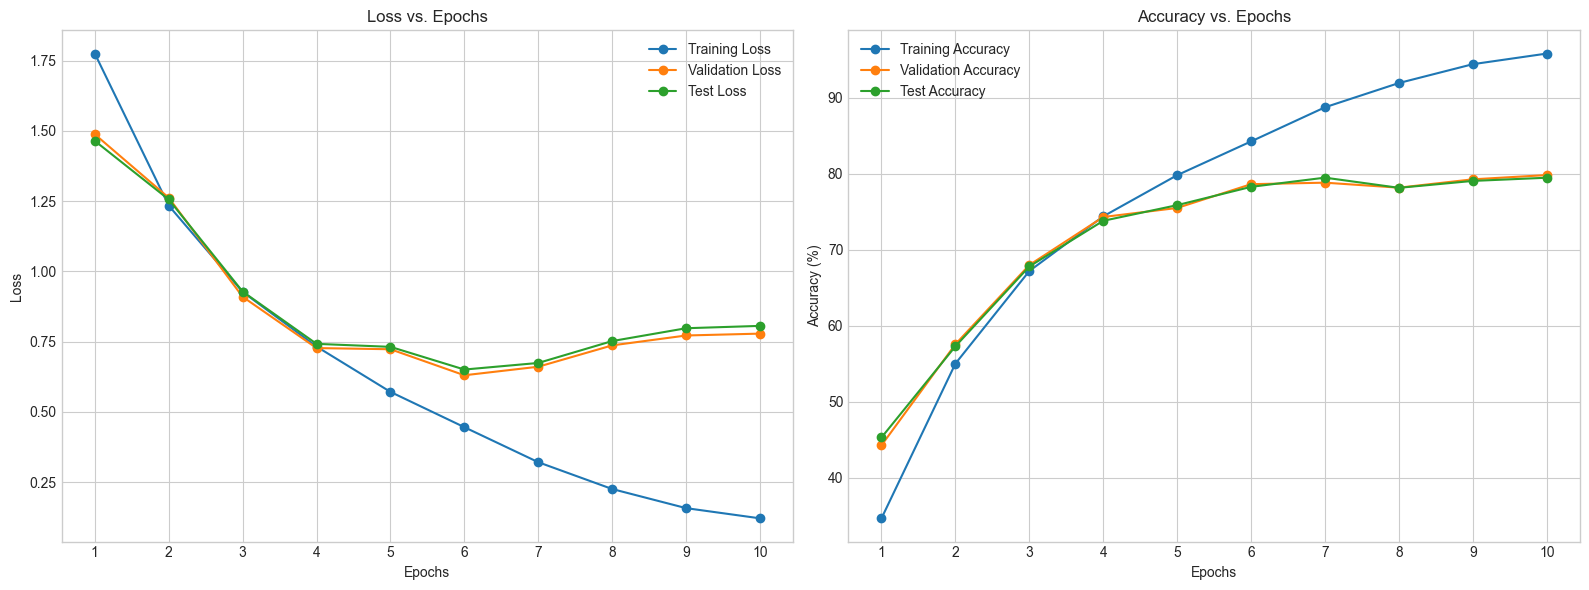

In [ ]:
plot_metrics(training_history)

In [59]:
final_test_loss, final_test_acc = evaluate_model(model_resnet, test_loader, loss_fn, device)

In [60]:
print(f'\nFinal accuracy on the 10000 test images: {final_test_acc:.2f}%')


Final accuracy on the 10000 test images: 79.47%
